# Testing of features in polysaccharide2

In [1]:
# Supressing annoying warnings (!must be done first!)
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning) # doesn't actually seem to do anything about mbuild warnings

# Logging
from polysaccharide2.genutils.logutils.IOHandlers import LOG_FORMATTER

import logging
LOGGER = logging.Logger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format =LOG_FORMATTER._fmt,
    datefmt=LOG_FORMATTER.datefmt,
    # force=True
)

# General
import re, json
from pathlib import Path
from shutil import copyfile

import numpy as np

# Logging
from rich.progress import Progress, track
import logging

# Chemistry
from openmm.unit import nanometer, angstrom
from openff.toolkit import Topology, Molecule, ForceField
from openff.units import unit as offunit

from openff.interchange import Interchange
from openff.interchange.components import _packmol as packmol

from rdkit import Chem
import openeye

# Custom
import polysaccharide2 as ps2
from polysaccharide2.genutils.decorators.functional import allow_string_paths, allow_pathlib_paths, optional_in_place

/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from .xtc import XTCTrajectoryFile
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/mbuild/recipes/__init__.py:13: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entry_points = metadata.entry_points()["mbuild.plugins"]
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creatin

# OpenFF parameterization testing

## Defining water

In [ ]:
from rdkit import Chem

from polysaccharide2.openfftools import TKREGS
from polysaccharide2.openfftools.topIO import save_molecule
from polysaccharide2.rdutils.labeling.molwise import assign_ordered_atom_map_nums

# rdwat = Chem.MolFromSmiles('O')
# assign_ordered_atom_map_nums(rdwat, in_place=True)
# offwat = Molecule.from_rdkit(rdwat)
def generate_water_TIP3P() -> Molecule:
    '''Helper method for creating a new TIP3p water representation from scratch'''
    TIP3P_ATOM_CHARGES = { # NOTE : units deliberately omitted here (become applied to entire charge array)
        'H' :  0.417,
        'O' : -0.843
    }

    water = Molecule.from_smiles('O')
    water.name = 'water_TIP3P'
    water.partial_charges = [TIP3P_ATOM_CHARGES[atom.symbol] for atom in water.atoms]*offunit.elementary_charge

    return water

In [ ]:
water_dir = Path('water_files')
water_dir.mkdir(exist_ok=True)

water = generate_water_TIP3P()

save_molecule(water_dir / f'{water.name}_oe.sdf' , water, TKREGS['OpenEye Toolkit'])
save_molecule(water_dir / f'{water.name}_rd.sdf', water, TKREGS['The RDKit'])
WATER_PATH = copyfile(water_dir / f'{water.name}_oe.sdf', water_dir / f'{water.name}.sdf')

## Testing load using from_pdb and monomers

In [ ]:
from polysaccharide2.openfftools import topIO
from polysaccharide2.openfftools.topinfo import get_largest_offmol
from polysaccharide2.residues.partition import partition
from polysaccharide2.monomers.repr import MonomerGroup

# pdb_dir  = Path('polymer_examples/compatible_pdbs/simple_polymers')
# mono_dir = Path('polymer_examples/monomer_generation/json_files/')

pdb_sub = 'simple_polymers'
pdb_dir  = Path(f'pdb_test_cleaned/pdbs/{pdb_sub}')
mono_dir = Path(f'pdb_test_cleaned/monos/{pdb_sub}')

mol_name = 'polyvinylchloride'
# mol_name = 'PEO_PLGA'
# mol_name = 'paam_modified'
# pdb_sub = 'proteins'
# mol_name = '6cww'

pdb = pdb_dir / f'{mol_name}.pdb'
mono = mono_dir / f'{mol_name}.json'
assert(pdb.exists())
assert(mono.exists())

monogrp = MonomerGroup.from_file(mono)
rdmol = Chem.MolFromPDBFile(str(pdb))
offtop = Topology.from_pdb(pdb, _custom_substructures=monogrp.monomers, toolkit_registry=TKREGS['The RDKit'])
was_partitioned = partition(offtop)
print(was_partitioned)

# assign properties to Molecule
offmol = get_largest_offmol(offtop)
offmol.name = mol_name
offmol.properties['solvent'] = None
offmol.properties['charge_method'] = None

# save partitioned Topology
sdf_dir = Path('sdf_test')
sdf_dir.mkdir(exist_ok=True)
mol_path = sdf_dir / f'{mol_name}.sdf'
topIO.topology_to_sdf(mol_path, offtop=offtop, toolkit_registry=TKREGS['The RDKit'])

## Partial charge assignment

In [ ]:
from polysaccharide2.openfftools import TKREGS
from polysaccharide2.openfftools import topIO
from polysaccharide2.residues.rescharge import application, calculation


base_charge_method = 'AM1-BCC-ELF10'

# assign charges with default methods
charged_mols = {}
for charge_method, ChargerType in application.MolCharger.subclass_registry.items():
    chgr = ChargerType()
    cmol = charged_mols[charge_method] = chgr.charge_molecule(offmol, in_place=False)

# generate library charges and charge by residue
res_chg = calculation.compute_residue_charges(charged_mols[base_charge_method], monogrp)
res_chg.to_file(sdf_dir / f'{mol_name}_residue_charges.json')

offmol_avg = application.apply_residue_charges(offmol, res_chg, in_place=False)
offmol_avg.properties['charge_method'] = 'RCT-averaged'
charged_mols['RCT-averaged'] = offmol_avg

# saving charged molecules to SDF files
for charge_method, cmol in charged_mols.items():
    topIO.topology_to_sdf(sdf_dir / f'{mol_name}_{charge_method}.sdf', cmol.to_topology())

## Solvation of Topologies

In [ ]:
from openmm.unit import gram, centimeter, nanometer, mole
from polysaccharide2.openfftools.solvation.packing import pack_topology_with_solvent

# PARAMETERS
targ_box_vecs = 4.1 * np.ones(3) * nanometer
density = 0.997 * (gram / centimeter**3)
exclusion = 1.3 * nanometer
solvent = Molecule.from_file(WATER_PATH)

for charge_method, cmol in charged_mols.items():
    # solv_top = pack_topology_with_solvent(cmol.to_topology(), solvent, box_vecs=targ_box_vecs, density=density, exclusion=exclusion)
    solv_top = pack_topology_with_solvent(cmol.to_topology(), solvent, box_vecs=targ_box_vecs, density=density, exclusion=exclusion)
    topIO.topology_to_sdf(sdf_dir / f'{mol_name}_{charge_method}_solv_{solvent.name}.sdf', solv_top)

# OpenMM I/O and simulation interfaces

## Cast OpenFF Topology to OpenMM via Interchange

In [ ]:
from openff.toolkit import ForceField
from openff.interchange import Interchange

from polysaccharide2.openfftools import FFDIR, topIO, topinfo
from polysaccharide2.openfftools.solvation import boxvectors
from polysaccharide2.genutils.unitutils import openff_to_openmm, openmm_to_openff


sdf_dir = Path('sdf_test')
sdf_path = sdf_dir / 'polyvinylchloride_AM1-BCC-ELF10.sdf'
offtop = topIO.topology_from_sdf(sdf_path)
offmol = topinfo.get_largest_offmol(offtop)

box_dims = 2.0 * np.ones(3) * nanometer
box_vecs = boxvectors.xyz_to_box_vectors(box_dims)
offtop.box_vectors = box_vecs

ff_name = 'openff-2.0.0.offxml'
ff = ForceField(FFDIR / ff_name)
ic = Interchange.from_smirnoff(ff, offtop, charge_from_molecules=[offmol])

ommtop = ic.to_openmm_topology()
ommsys = ic.to_openmm(combine_nonbonded_forces=False, add_constrained_forces=False)
ommpos = openff_to_openmm(ic.positions)

## Initialize OpenMM sim + files

In [ ]:
from openmm.unit import nanosecond, picosecond, femtosecond
from openmm.unit import kelvin, atmosphere, nanometer
from polysaccharide2.openmmtools import parameters, serialization, preparation


# define paths
prefix = 'pvc'
save_path = Path('openmm_test')
save_path.mkdir(exist_ok=True)

# initialize parameter sets
sim_params = parameters.SimulationParameters(
    integ_params=parameters.IntegratorParameters(
        time_step=1*femtosecond,
        total_time=100*picosecond,
        num_samples=100
    ),
    thermo_params=parameters.ThermoParameters(
        ensemble='NVT',
        temperature=300*kelvin,
        pressure=1*atmosphere
    ),
    reporter_params=parameters.ReporterParameters(
        report_state=True,
        report_checkpoint=True,
        report_state_data=True,
        report_trajectory=True,
    ),
)

# initialize and integrate simulation
ommsim, sim_paths = preparation.initialize_simulation_and_files(save_path, prefix, sim_params, ommtop, ommsys)
ommsim.context.setPositions(ommpos) # by default, positions are unnasigned

LOGGER.info('Performing energy minimization')
ommsim.minimizeEnergy()
LOGGER.info('Energy successfully minimized')

serialization.serialize_topology_from_simulation(sim_paths.topology_path, ommsim) # TODO : make this consistent with rest of Path output
LOGGER.info(f'Saved energy-minimized Simulation Topology at {sim_paths.topology_path}')

serialization.serialize_system(sim_paths.system_path, ommsim.system)
LOGGER.info(f'Saved serialized Simulation System at {sim_paths.system_path}')

LOGGER.info(f'Integrating {sim_params.integ_params.total_time} OpenMM sim for {sim_params.integ_params.num_steps} steps')
ommsim.step(sim_params.integ_params.num_steps)
LOGGER.info('Simulation integration completed successfully')

### Copying coordinate to single chain after anneal

In [ ]:
from copy import deepcopy

final_state = ommsim.context.getState(getPositions=True)
final_pos = final_state.getPositions(asNumpy=True)

new_mol = deepcopy(offmol)
new_mol.conformers[0] = openmm_to_openff(final_pos.in_units_of(angstrom)) # convert to correct units in the OpenFF format

In [ ]:
topIO.topology_to_sdf('orig.sdf', offmol.to_topology())
topIO.topology_to_sdf('shifted.sdf', new_mol.to_topology())

# Experimenting with SMARTS functional groups

In [ ]:
from polysaccharide2.monomers.substruct.functgroups import FN_GROUP_TABLE, FN_GROUP_ENTRIES
from polysaccharide2.monomers.substruct.functgroups.records import FnGroupSMARTSEntry

In [ ]:
FN_GROUP_TABLE.loc[FN_GROUP_TABLE['group_type'].str.contains('carbonyl')]

In [ ]:
smarts = FN_GROUP_ENTRIES[44].SMARTS
Chem.MolFromSmarts(smarts)

# Testing building

In [2]:
from pathlib import Path
from polysaccharide2.monomers.repr import MonomerGroup
from polysaccharide2.polymers import estimation, building
from polysaccharide2.openfftools import TKREGS, topIO, topinfo
from polysaccharide2.residues.partition import partition


# building parameters
DOP = 8
term_groups = { 
    'peg_modified' : {
        'peg_TERM2' : 'head',
        'peg_TERM3' : 'tail',
    },
    'paam_modified' : {
        'paam_TERM2' : 'head',
        'paam_TERM3' : 'tail',
    },
    'pnipam_modified' : {
        'pnipam_TERM2' : 'head',
        'pnipam_TERM3' : 'tail',
    },
}

outdir = Path('polybuild_test')
outdir.mkdir(exist_ok=True)

# defining paths
mol_category = 'simple_polymers'
pdb_dir  = Path(f'pdb_test_cleaned/pdbs/{mol_category}')
mono_dir = Path(f'pdb_test_cleaned/monos/{mol_category}')

# estimation and building loop
monogrps = {}
offmols  = {}
for mol_name, term_group_orient in term_groups.items():
    pdb_path   = outdir / f'{mol_name}.pdb' # NOTe : new PDB path, not an existing one
    mono_path = mono_dir / f'{mol_name}.json'
    assert(mono_path.exists())

    monogrp = MonomerGroup.from_file(mono_path)
    monogrps[mol_name] = monogrp
    chain = building.build_linear_polymer(monogrp, DOP, term_orient=term_group_orient)
    building.mbmol_to_openmm_pdb(pdb_path, chain)
    
    offtop = Topology.from_pdb(pdb_path, _custom_substructures=monogrp.monomers, toolkit_registry=TKREGS['The RDKit']) # verify that Topologies can be loaded from new mols
    was_partitioned = partition(offtop) 
    assert(was_partitioned)
    offmol = topinfo.get_largest_offmol(offtop)
    offmol.name = mol_name
    offmols[mol_name] = offmol

2023-10-06 17:42:03.035 [INFO    :        building:line 82  ] - Building linear polymer chain with 8 monomers (65 atoms)
2023-10-06 17:42:04.348 [INFO    :        building:line 82  ] - Building linear polymer chain with 8 monomers (82 atoms)
2023-10-06 17:42:05.462 [INFO    :        building:line 82  ] - Building linear polymer chain with 8 monomers (154 atoms)


In [4]:
from polysaccharide2.openfftools import pcharge
from polysaccharide2.residues.rescharge import calculation
from polysaccharide2.residues.rescharge.interface import LibraryCharger


chgr = pcharge.EspalomaCharger()
cmol = chgr.charge_molecule(offmols['peg_modified'], in_place=False)
lib_chgs = calculation.compute_residue_charges(cmol, monogrps['peg_modified'])

lib_chgr = LibraryCharger(lib_chgs)
cmol2 = lib_chgr.charge_molecule(offmols['peg_modified'], in_place=False)

2023-10-06 17:44:07.315 [INFO    :         pcharge:line 34  ] - Assigning partial charges via the "Espaloma-AM1-BCC" method


/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/espaloma_charge/openff_wrapper.py:112: IncorrectNumConformersWarning: Molecule 'Molecule with name 'peg_modified' and SMILES '[H]C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])C([H])([H])OC([H])([H])[H]'' has 1 conformers, but charge method 'espaloma-am1bcc' expects exactly 0.
  self._check_n_conformers(
2023-10-06 17:44:07.385 [INFO    :         pcharge:line 37  ] - Successfully assigned "Espaloma-AM1-BCC" charges
2023-10-06 17:44:07.408 [INFO    :         pcharge:line 34  ] - Assigning partial charges via the "RCT_residue_charges" method
2023-10-06 17:44:07.410 [INFO    :         pcharge:line 37  ] - Successfully assigned "RCT_residue_charges" charges


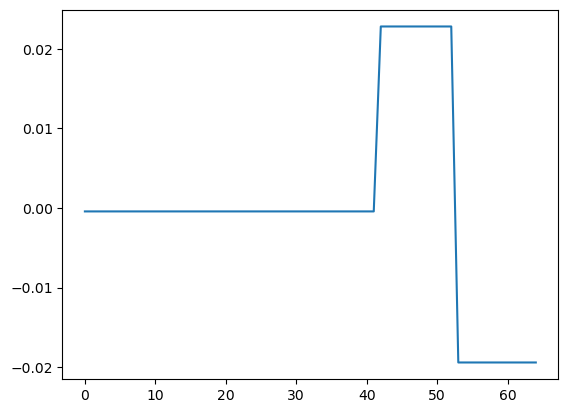

In [5]:
import matplotlib.pyplot as plt

diff = cmol.partial_charges - cmol2.partial_charges
plt.plot(diff)

In [12]:
diffs = [
    atom.partial_charge - cmol2.atoms[atom.molecule_atom_index].partial_charge
        for atom in cmol.atoms
]

In [13]:
diffs

[-0.0004287596641879346 <Unit('elementary_charge')>,
 -0.00042875966418794154 <Unit('elementary_charge')>,
 -0.00042875966418794154 <Unit('elementary_charge')>,
 -0.000428747246553611 <Unit('elementary_charge')>,
 -0.00042875966418794154 <Unit('elementary_charge')>,
 -0.00042875966418794154 <Unit('elementary_charge')>,
 -0.00042875966418792766 <Unit('elementary_charge')>,
 -0.0004287596641879346 <Unit('elementary_charge')>,
 -0.00042875966418794154 <Unit('elementary_charge')>,
 -0.00042875966418794154 <Unit('elementary_charge')>,
 -0.00042876214771480486 <Unit('elementary_charge')>,
 -0.00042875966418794154 <Unit('elementary_charge')>,
 -0.00042875966418794154 <Unit('elementary_charge')>,
 -0.00042875966418792766 <Unit('elementary_charge')>,
 -0.0004287596641879346 <Unit('elementary_charge')>,
 -0.00042875966418794154 <Unit('elementary_charge')>,
 -0.00042875966418794154 <Unit('elementary_charge')>,
 -0.00042876214771480486 <Unit('elementary_charge')>,
 -0.00042875966418794154 <Unit('e

# Playing with ratios

In [ ]:
from dataclasses import dataclass
from typing import Any, Callable, ClassVar, TypeVar
from math import gcd
from numbers import Number


N = TypeVar('N')
def sgnmag(num : N) -> tuple[bool, N]:
    '''Returns the sign and magnitude of a numeric-like value'''
    return num < 0, abs(num)


@dataclass(repr=False)
class Ratio:
    '''For representing fractional ratios between two objects'''
    num   : Any
    denom : Any

    # REPRESENTATION
    def __repr__(self) -> str:
        return f'{self.num}/{self.denom}'
    
    def to_latex(self) -> str:
        '''Return latex-compatible string which represent fraction'''
        return rf'\frac{{{self.num}}}{{{self.denom}}}'

    # RELATIONS
    @property
    def reciprocal(self) -> 'Ratio':
        '''Return the reciprocal of a ration'''
        return self.__class__(self.denom, self.num)


@dataclass(repr=False)
class Rational(Ratio):
    '''For representing ratios of integers'''
    num   : int
    denom : int

    # REDUCTION
    autoreduce : ClassVar[bool]=False
    
    def __post_init__(self) -> None:
        if self.__class__.autoreduce:
            self.reduce()

    def reduce(self) -> None:
        '''Reduce numerator and denominator by greatest common factor'''
        _gcd = gcd(self.num, self.denom)
        self.num=int(self.num / _gcd)
        self.denom=int(self.denom / _gcd)
    simplify = reduce # alias for convenience

    @property
    def reduced(self) -> 'Rational':
        '''Return reduced Rational equivalent to the current rational (does not modify in-place)'''
        new_rat = self.__class__(self.num, self.denom)
        new_rat.reduce()

        return new_rat
    simplifed = reduced # alias for convenience
    
    def as_proper(self) -> tuple[int, 'Rational']:
        '''Returns the integer and proper fractional component of a ratio'''
        integ, remain = divmod(self.num, self.denom)
        return integ, self.__class__(remain, self.denom)
    
    # ARITHMETIC
    def __add__(self, other : 'Rational') -> 'Rational':
        '''Sum of two Rationals'''
        return self.__class__(
            num=(self.num * other.denom) + (self.denom * other.num),
            denom=(self.denom * other.denom)
        )
    
    def __sub__(self, other : 'Rational') -> 'Rational':
        '''Difference of two Rationals'''
        return self.__class__(
            num=(self.num * other.denom) - (self.denom * other.num),
            denom=(self.denom * other.denom)
        )

    def __mul__(self, other : 'Rational') -> 'Rational':
        '''Product of two Rationals'''
        return self.__class__(
            num=self.num * other.num,
            denom=self.denom * other.denom
        )

    def __div__(self, other : 'Rational') -> 'Rational':
        '''Quotient of two Rationals'''
        return self.__class__(
            num=self.num * other.denom,
            denom=self.denom * other.num
        )
    
    def __pow__(self, power : float) -> 'Rational':
        '''Exponentiates a ratio'''
        return self.__class__(
            num=self.num**power,
            denom=self.denom**power
        )

In [ ]:
p = Rational(3, 6)
q = Rational(4, 12)

print(p, p.reciprocal, p.reduced, p+q)

In [ ]:
Rational.autoreduce = False

In [ ]:
import numpy as np
from numbers import Number

for val in (4, 4.0, 4+0j, np.pi, '4', [4], False, 'sgdfg'):
    print(val, type(val), isinstance(val, Number))

In [ ]:
from fractions import Fraction